# Fitting neutrino oscillations with IceCube DeepCore
***Bruno Benkel***, *PhD. student at DESY Zeuthen.*

For details on the analysis please see [Measurement of atmospheric neutrino mixing with improved IceCube DeepCore calibration and data processing](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.108.012014), published in Phys. Rev. D 108, 012014 (2023).

Here we present a fit of MC to de data. The aim of this analysis is to show end users how to:
* treat the MC and data;
* compute flux using `daemonflux` (see the [publication](https://arxiv.org/abs/2303.00022) and [repository](https://github.com/mceq-project/daemonflux));
* calculate neutrino oscillation parameters using a 2-flavor approximation; and
* re-weight MC events using hypersurfaces, as presented in the analysis publication.

Note that the fit is very simplistic and we ignore many systematic uncertainties, e.g. flux, cross-section, atmospheric muon scale, and normalization. Therefore, we do not expect a high-quality result, but just to provide an easy-to-follow procedure.

This notebook was developed using Python version 3.10.2. Each package and its version are
* `numpy`: 2.2.0.
* `pandas`: 2.2.3.
* `scipy`: 1.14.1.
* `matplotlib`: 3.9.3.
* `daemonflux`: 0.8.2.

In [1]:
import numpy as np # Array handling.
import pandas as pd # Data handling.
from scipy import optimize # Fitting.
import matplotlib.pyplot as plt # Plotting.

import daemonflux # Flux estimation.

from copy import deepcopy # Misc.

---
First, we import the `.csv` files into pandas dataframes then setup binning and livetime from the publication.

In [2]:
# Load the data files.
PATH = "./"
DSETS = [
    "data",                                               # Data.
    "mc_nu_nc", "mc_nue_cc", "mc_numu_cc", "mc_nutau_cc", # MC neutrinos.
    "mc_mu",                                              # MC muons.
    "hs_nu_nc_nue_cc", "hs_numu_cc", "hs_nutau_cc"        # Hypersurfaces.
]
dfs = {dataset: pd.read_csv(PATH + dataset + ".csv") for dataset in DSETS}

# Combine MC neutrino sets.
dfs["mc_nu"] = pd.DataFrame()
for k, df in [(k, v) for k, v in dfs.items() if "mc_nu" in k and k != "mc_nu"]:
    dfs["mc_nu"] = pd.concat([dfs["mc_nu"], df], axis=0, ignore_index=True)
    del dfs[k]

# Create quick references to dict entries.
data, mcnu, mcmu = dfs["data"], dfs["mc_nu"], dfs["mc_mu"]
dhs = {k: df for k, df in dfs.items() if "hs" in k}

In [3]:
# Setup binning from the readme.
EN_MIN, EN_MAX = 6.31, 158.49
CZ_MIN, CZ_MAX = -1., .1

BINS = {
    "reco_energy" : np.logspace(np.log10(EN_MIN), np.log10(EN_MAX), num=12),
    "reco_coszen" : np.linspace(CZ_MIN, CZ_MAX, num=11),
    "pid"         : np.array([0.55, 0.75, 1.00]),
}

# Last energy bin has double size to contain sufficient statistics.
BINS["reco_energy"] = np.delete(BINS["reco_energy"], -2)

# Calculate livetime from Table III in https://arxiv.org/abs/2304.12236.
YEAR2SEC = 31557600
PAPER_CONDS = {
    11: [96.4/1e6, 0.67],
    12: [93.0/1e6, 0.87],
    13: [90.0/1e6, 0.92],
    14: [93.7/1e6, 0.96],
    15: [95.3/1e6, 0.98],
    16: [90.1/1e6, 0.96],
    17: [94.1/1e6, 1.10],
    18: [94.1/1e6, 0.99],
}
NUCOUNT = sum([YEAR2SEC * v[0] * v[1] for v in PAPER_CONDS.values()])

---
Then, we estimate neutrino flux using `daemonflux` and prepare functions to estimate neutrino oscillation using the 2-flavor approximation.

In [4]:
# Downsize input MC data for expediency.
SCALING_FACTOR = 10
mcnu = mcnu.iloc[::SCALING_FACTOR, :].reset_index(drop=True)

# Normalize weights after scaling.
mcnu["weight"] *= SCALING_FACTOR

In [5]:
# Get flux using daemonflux (see https://github.com/mceq-project/daemonflux).
FLAVORS = ("nue", "numu")
dflux = daemonflux.Flux(location = "generic")

# Store nu flux in corresponding arrays.
flux = {}
for fl in FLAVORS:
    flux[fl] = np.zeros_like(mcnu["weight"])

print("Progress:")
for ei in range(len(mcnu)):
    # Check if nu or antinu.
    prefix = ""
    if mcnu["pdg"][ei] < 0: prefix = "anti"

    # Get zenith angle in degrees, from -90 to 90.
    zen = np.rad2deg(np.arccos(mcnu["true_coszen"][ei]))
    if zen > 90: zen = 180-zen

    # Get flux.
    for fl in FLAVORS:
        flux[fl][ei] = dflux.flux([mcnu["true_energy"][ei]], zen, prefix+fl)

    # Print progress.
    if ei % 1e4 == 0: print("%6d | %6d" % (ei, len(mcnu)))
print("Done!")

# Correct flux -- daemonflux reports E^3 * flux in [GeV^-4 m^-2 s^-1 sr^-1], our
#     weight is in [GeV cm^2 sr].
for fl in FLAVORS:
    flux[fl] *= 1e4 # m^2 -> cm^2.
    mcnu[fl + "_flux"] = flux[fl] / pow(mcnu["true_energy"], 3) # GeV^-4 -> -1.

Progress:
     0 |  39685
 10000 |  39685
 20000 |  39685
 30000 |  39685
Done!


In [6]:
# Constants to associate zenith angle with distance.
L1 = 19.
R  = 6378.2 + L1
def zen_to_d(coszen: float) -> float:
    """
    Converts the cosine of the zenith angle into distance.

    Args:
        coszen  : cosine of the zenith angle of the event.
        returns : event's distance in meters.
    """
    zen = np.arccos(coszen)
    phi = np.arcsin((1-L1/R) * np.sin(zen))
    psi = zen - phi
    return np.sqrt((R-L1)**2 + R**2 - (2*(R-L1) * R * np.cos(psi)))

In [7]:
# Define functions to obtain oscillated flux, so that we can later fit.
TAGS = {
    "nu_nc"    :  mcnu["type"] == 0,
    "nue_nc"   : (mcnu["type"] == 0) * (mcnu["pdg"]%12 == 0),
    "numu_nc"  : (mcnu["type"] == 0) * (mcnu["pdg"]%14 == 0),
    "nue_cc"   : (mcnu["type"] != 0) * (mcnu["pdg"]%12 == 0),
    "numu_cc"  : (mcnu["type"] != 0) * (mcnu["pdg"]%14 == 0),
    "nutau_cc" : (mcnu["type"] != 0) * (mcnu["pdg"]%16 == 0),
}

def osc_flux(mcnu: pd.DataFrame, amp: float, dm31: float) -> list[float]:
    """
    Computes neutrino transition probability using the 2-flavor approximation,
    returning an oscillated flux array that takes muon neutrino disappearance
    and tau neutrino appearance into account.

    Args:
        mcnu    : pandas dataframe with MC neutrinos.
        amp     : real value for the sin2(2 * theta23) in the 2-flavor approx-
                  imation.
        dm31    : neutrino mass splitting in eV^2.
        returns : array with the oscillated flux.
    """
    prop_distance = zen_to_d(mcnu["true_coszen"]) / mcnu["true_energy"]
    ptau = amp * np.sin(1.267 * dm31 * prop_distance)**2

    # Compute oscillated flux.
    oflux = np.zeros_like(mcnu["weight"])

    for fl in FLAVORS:
        oflux[TAGS[fl+"_nc"]] = deepcopy(mcnu[fl+"_flux"][TAGS[fl+"_nc"]])
    oflux[TAGS["nue_cc"]]   = deepcopy(mcnu["nue_flux"][TAGS["nue_cc"]])
    oflux[TAGS["numu_cc"]]  = mcnu["numu_flux"][TAGS["numu_cc"]] *\
                              (1-ptau[TAGS["numu_cc"]])
    oflux[TAGS["nutau_cc"]] = mcnu["numu_flux"][TAGS["nutau_cc"]] *\
                              ptau[TAGS["nutau_cc"]]

    return oflux

---
Prepare functions to reweight the MC neutrino histogram. We also plot a histogram to show the effect of this reweighting for an example mass splitting value.

In [8]:
# Setup hypersurfaces parameters.
NOMINAL_SYSTEMATICS = { # From readme.
    "dom_eff"          :  1.00,
    "hole_ice_p0"      :  0.10,
    "hole_ice_p1"      : -0.05,
    "bulk_ice_abs"     :  1.00,
    "bulk_ice_scatter" :  1.00,
}

def get_corr_factors(hs: pd.DataFrame, fit: dict[str, float]) -> pd.Series:
    """
    Computes the hypersurfaces correction factors for a given fit.

    Args:
        hs      : pandas dataframe with the binned hypersurfaces gradients.
        fit     : detector systematics to be tested.
        returns : array hypersurfaces correction for each bin.
    """
    # Compute difference between fit and nominal.
    diff = {k: v - NOMINAL_SYSTEMATICS[k] for k, v in fit.items()}
    return hs["intercept"] + sum([hs[k] * v for k, v in diff.items()])

In [9]:
HIST_SHAPE = tuple(map(lambda v: len(v)-1, [v for v in BINS.values()]))
def make_mcnu_hist(
    mcnu: pd.DataFrame, dhs: dict[str, pd.DataFrame] = None, dm31: float = None,
    fit: dict[str, float] = None
) -> np.ndarray[HIST_SHAPE, float]:
    """
    Makes four histograms from MC neutrino dataframe (nu_nc, nue_cc, numu_cc,
    nutau_cc), applies hypersurfaces corrections to each, and returns the sum of
    each histogram.

    Args:
        mcnu    : pandas dataframe with the MC neutrinos.
        dhs     : dictionary with hypersurface for each dm31 value.
        dm31    : mass splitting value to be tested.
        fit     : detector systematics to be tested.
        returns : histogram with the corrected MC neutrinos.
    """

    # Assert that dm31 is within the hypersurfaces interpolation range.
    dm31bins = dhs["hs_numu_cc"]["dm31"].unique()
    if dm31 < dm31bins.min() or dm31bins.max() < dm31:
        raise ValueError("dm31 of %f is outside of interpolation range." % dm31)

    # Get dm31 bin length.
    binlen = dm31bins[1] - dm31bins[0]

    # Separate MC nu dataframe.
    mc = {
        "nu_nc"    : mcnu[(mcnu["type"] == 0)],
        "nue_cc"   : mcnu[(mcnu["type"] != 0) & (abs(mcnu["pdg"]) == 12)],
        "numu_cc"  : mcnu[(mcnu["type"] != 0) & (abs(mcnu["pdg"]) == 14)],
        "nutau_cc" : mcnu[(mcnu["type"] != 0) & (abs(mcnu["pdg"]) == 16)],
    }
    # Prepare sum of histograms.
    hist_total, _ = np.histogramdd([[], [], []], bins = list(BINS.values()))

    # Iterate through neutrino flavors.
    for flavor, df in mc.items():
        # Make MC histogram.
        hist, _ = np.histogramdd(
            [df["reco_energy"], df["reco_coszen"], df["pid"]],
            weights = NUCOUNT * df["osc_flux"] * df["weight"],
            bins = list(BINS.values())
        )

        # Apply hypersurfaces correction.
        if all(par is not None for par in [dhs, dm31, fit]):
            # Get the right HS entry.
            hs = [df for key, df in dhs.items() if flavor in key][0]

            # Get hypersurface below and above dm31.
            hs_lower = hs.loc[
                (dm31 - binlen < hs["dm31"]) & (hs["dm31"] < dm31)
            ].reset_index()
            hs_upper = hs.loc[
                (dm31 < hs["dm31"]) & (hs["dm31"] < dm31 + binlen)
            ].reset_index()

            # Create the interpolated hypersurface.
            hs_int = hs_lower.copy()
            for p in fit.keys():
                grad = (np.array(hs_upper[p]) - np.array(hs_lower[p])) / binlen
                hs_int[p] = grad * (dm31 - hs_lower["dm31"][0]) + hs_lower[p]

            # Compute the correction factors.
            corr_factors = get_corr_factors(hs_int, fit)
            
            # Make the HS correction histogram.
            hs_corr, _ = np.histogramdd(
                [hs_int["reco_energy"], hs_int["reco_coszen"], hs_int["pid"]],
                weights = corr_factors, bins = list(BINS.values())
            )

            # Apply HS correction.
            hist *= hs_corr

        # Add corrected histogram to total.
        hist_total += hist

    # Return sum of MC neutrino histograms.
    return hist_total

In [10]:
def plot_hist(hist: np.ndarray[HIST_SHAPE, float], cmap: str = "OrRd"):
    """
    Plot a 3D histogram, separating it into two 2D histograms by PID.

    Args:
        hist : histogram we should plot.
        cmap : color map to use. Default is "OrRd".
    """
    fig, axs = plt.subplots(ncols = 2, figsize = (9, 4), sharey = "row")

    # Iterate through PID bins.
    for pi in range(len(BINS["pid"]) - 1):
        # Draw the histogram.
        phist = axs[pi].pcolormesh(
            BINS["reco_energy"], BINS["reco_coszen"],
            hist[:,:,pi].T, cmap=cmap, vmin=np.min(hist), vmax=np.max(hist)
        )

        # Setup axes and titles.
        axs[pi].set_xscale("log")
        XTICKS = np.logspace(3, 7, num=5, base=2)
        axs[pi].set_xticks(XTICKS, XTICKS.astype(int))
        axs[pi].set_xlabel(r"$E_\text{reco}$ (GeV)")
        axs[pi].set_title("Mixed" if BINS["pid"][pi] == 0.55 else "Tracks")
    axs[0].set_ylabel(r"$\cos \theta_\text{reco}$")
    plt.tight_layout()

    fig.subplots_adjust(right=0.95)
    cbar = fig.colorbar(phist, ax=axs)
    if cmap == "RdBu_r": cbar.set_label("Percent change")
    else:                cbar.set_label("Count")

    plt.show()    

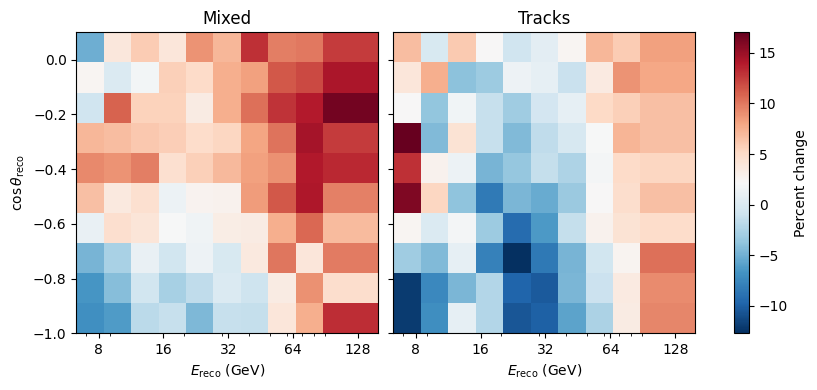

In [11]:
BESTFIT_SYSTEMATICS = { # From Table IV in https://arxiv.org/abs/2304.12236.
    "dom_eff"          :  1.06,
    "hole_ice_p0"      : -0.27,
    "hole_ice_p1"      : -0.04,
    "bulk_ice_abs"     :  0.97,
    "bulk_ice_scatter" :  0.99,
}

# Prepare some test parameters for the oscillated flux.
TEST_AMP  = 1.
TEST_DM31 = 2.2e-3
mcnu["osc_flux"] = osc_flux(mcnu, TEST_AMP, TEST_DM31)

# Make MC neutrino histograms.
hist_nom = make_mcnu_hist(mcnu, dhs, TEST_DM31, NOMINAL_SYSTEMATICS)
hist_bf  = make_mcnu_hist(mcnu, dhs, TEST_DM31, BESTFIT_SYSTEMATICS)

# Plot.
plot_hist(100 * (hist_bf - hist_nom) / hist_nom, cmap="RdBu_r")

---
Make data and MC muon histograms, then plot them for visual inspection.

Please note that in this analysis we are not accounting for many of the systematics in Table IV, which should explain the difference in scale between data events and MC.

In [12]:
# Data histogram - we won't change this.
h_data, _ = np.histogramdd(
    [data["reco_energy"], data["reco_coszen"], data["pid"]],
    bins = list(BINS.values()), weights = data["count"]
)

# MC neutrino histogram with systematics in best fit.
h_mcnu = make_mcnu_hist(mcnu, dhs, TEST_DM31, BESTFIT_SYSTEMATICS)

# MC muon histogram - in this analysis we won't change this, but rescale it by a
#     factor. Note that the paper uses a scaling factor of 1.39, but we keep the
#     parameter free for this simplistic fit.
h_mcmu, _ = np.histogramdd(
    [mcmu["reco_energy"], mcmu["reco_coszen"], mcmu["pid"]],
    bins = list(BINS.values()), weights = mcmu["count"]
)

Data events (sum: 21914)


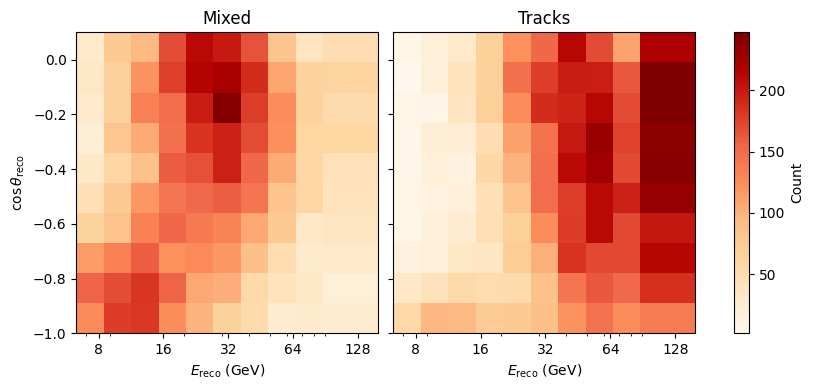

MC events (sum: 22171)


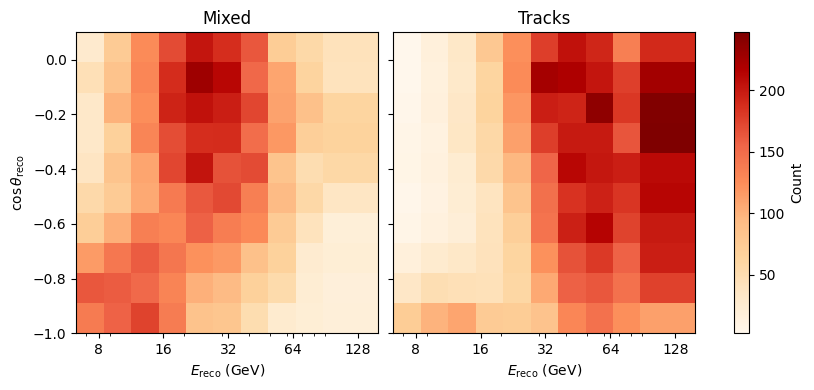

In [13]:
print("Data events (sum: %d)" % h_data.sum())
plot_hist(h_data)

print("MC events (sum: %d)" % (h_mcnu.sum() + h_mcmu.sum()))
plot_hist(h_mcnu + h_mcmu)

---
Prepare functions necessary for the analysis, like reweighting the MC neutrino histogram with different physics parameters and a modified $\chi^2$ measure.

In [14]:
def eval_weights(
    mcnu: pd.DataFrame, h_data: np.ndarray[HIST_SHAPE, float],
    h_mcmu: np.ndarray[HIST_SHAPE, float], dhs: dict[str, pd.DataFrame],
    amp: float, dm31: float, mu_frac: float
) -> tuple[np.ndarray[HIST_SHAPE, float], np.ndarray[HIST_SHAPE, float]]:
    """
    Makes the MC neutrino histogram re-evaluating the weights based on an oscil-
    lated flux evaluated from physics parameters. Then, returns both the MC neu-
    trino and MC muon histograms rescaled by a global factor.

    Args:
        mcnu    : pandas dataframe with MC neutrino data.
        h_data  : numpy array with 3D data histogram.
        h_mcmu  : numpy array with 3D MC muon histogram.
        dhs     : dictionary with hypersurface for each dm31 value.
        amp     : real value for the sin2(2 * theta23) in the 2-flavor approx-
                  imation.
        dm31    : neutrino mass splitting in eV^2.
        mu_frac : fraction of the sample composed of atmospheric muon back-
                  ground.
        returns : MC neutrino and muon histograms, scaled by mu_frac.
    """
    # Get oscillated weight.
    mcnu["osc_flux"] = osc_flux(mcnu, amp, dm31)

    # Make the MC neutrino histogram.
    h_mcnu = make_mcnu_hist(mcnu, dhs, dm31, BESTFIT_SYSTEMATICS)
    
    # Scale the number of nu events to match the data.
    nu_scale = h_data.sum() * (1 - mu_frac) / h_mcnu.sum()
    mu_scale = h_data.sum() * mu_frac       / h_mcmu.sum()

    return nu_scale * h_mcnu, mu_scale * h_mcmu

In [15]:
def draw_1Dplots(
    h_data: np.ndarray[HIST_SHAPE, float], h_mc: np.ndarray[HIST_SHAPE, float]
):
    """
    Draws a set of 1D plots to compare the expectation from MC neutrinos and
    muons with the data.

    Args:
        h_data : numpy array with the 3D data histogram.
        h_mc   : numpy array with the 3D MC neutrino and muon histograms added
                 together.
    """
    BE, BC, BP = BINS["reco_energy"], BINS["reco_coszen"], BINS["pid"]
    NROWS, NCOLS = len(BE)-1, len(BP)-1
    fig, axs = plt.subplots(
        nrows = NROWS, ncols = NCOLS, figsize = (7,12), sharex = True
    )

    for ci in range(NCOLS):
        for ri in range(NROWS):
            # Draw expectation.
            bc = np.append(h_mc[ri,:,ci], np.array([h_mc[ri,-1,ci]]))
            axs[ri][ci].fill_between(
                BC, bc-np.sqrt(bc), bc+np.sqrt(bc), color="coral", step="post",
                label="Expectation"
            )

            # Draw data.
            axs[ri][ci].stairs(h_data[ri,:,ci], BC, color="k", label="Data")

    axs[0][0].set_title("Mixed")
    axs[0][1].set_title("Tracks")
    for ci in range(NCOLS):
        axs[NROWS-1][ci].set_xlabel(r"$\cos(\theta_\text{reco})$")
    for ri in range(NROWS):
        axs[ri][0].set_ylabel("Count")
        axs[ri][0].text(
            0.3, 0.1, "E = [%4.1f, %4.1f] GeV" % (BE[ri], BE[ri+1]),
            transform = axs[ri][0].transAxes
        )

    axs[0][1].legend()
    plt.tight_layout()
    plt.show()

In [16]:
def chi2(params: list[float]) -> float:
    """
    Calculates a simplified chi2. For simplicity, this function assumes that
    `mcnu`, `h_data`, and `h_mcmu` are defined outside the scope of this func-
    tion.

    Args:
        params  : list containing the amplitude, dm31, and muon fraction.
        returns : the calculated chi2.
    """
    amp     = params[0]
    dm31    = params[1]
    mu_frac = params[2]

    # Get MC histogram.
    h_mcnu_s, h_mcmu_s = eval_weights(
        mcnu, h_data, h_mcmu, dhs, amp, dm31, mu_frac
    )
    mc_total = h_mcnu_s + h_mcmu_s

    # Compute and return chi2.
    chi2 = (h_data - mc_total)**2 / mc_total
    chi2[np.isnan(chi2)] = 0.
    return chi2.sum() / (len(params) * np.sqrt(np.sum(h_data)))

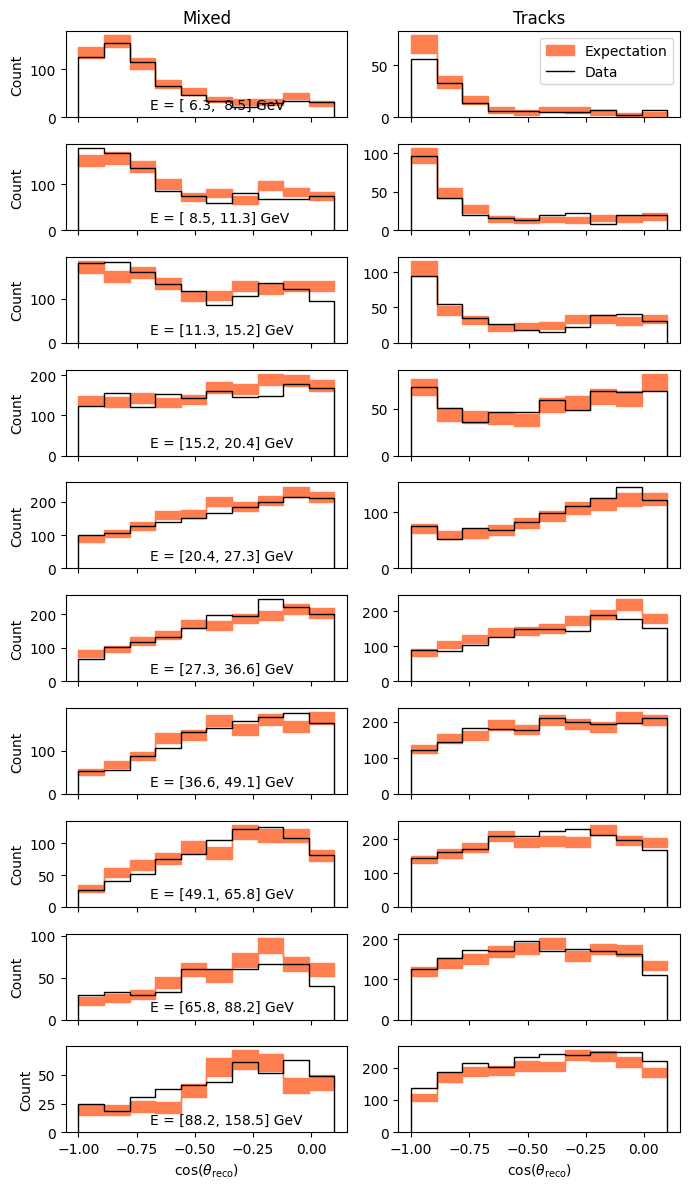

In [17]:
# Draw 1D plots with test parameters to see if we get something sensible.
TEST_MUFRAC = 0.05
h_mcnu_s, h_mcmu_s = eval_weights(
    mcnu, h_data, h_mcmu, dhs, TEST_AMP, TEST_DM31, TEST_MUFRAC
)
draw_1Dplots(h_data, h_mcnu_s+h_mcmu_s)

---
Run the fit and plot results.

amp      = 1.000000
dm32^2   = 0.002278
mu_scale = 0.040665
chi2     = 0.835396 (dof: 3)


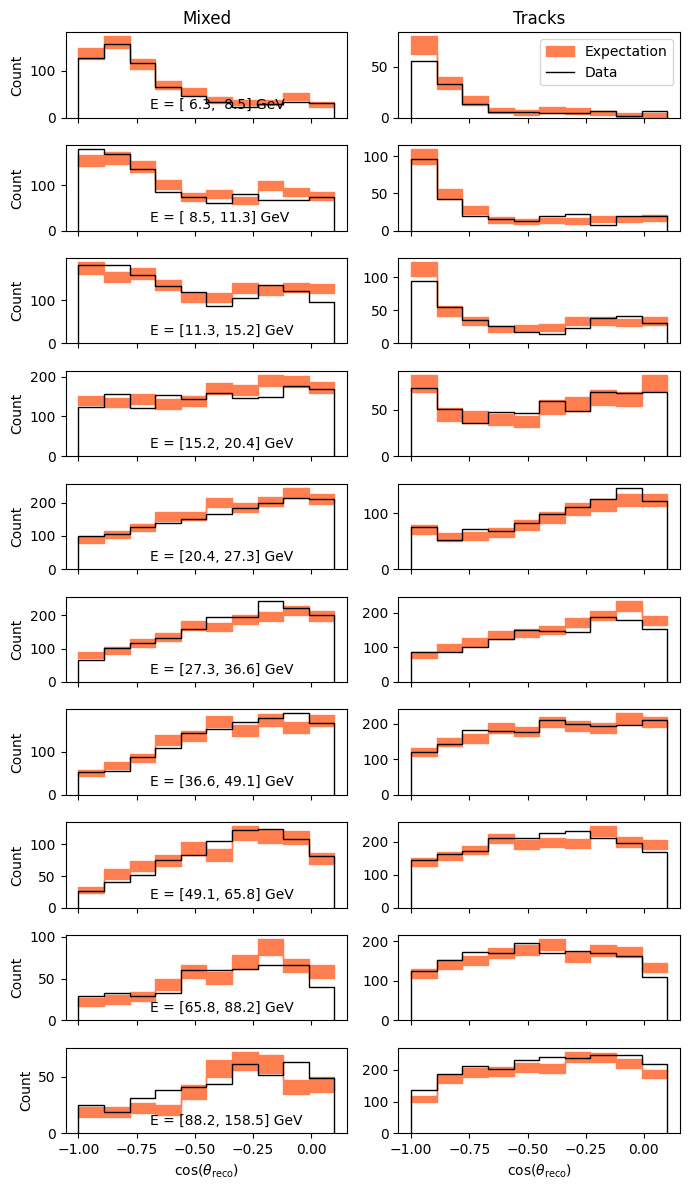

In [18]:
dm31_bins = dhs["hs_numu_cc"]["dm31"].unique()
BOUNDS = [
    (0., 1.), (dm31_bins.min() + 1e-5, dm31_bins.max() - 1e-5), (0., 1.)
]
result = optimize.minimize(
    chi2, [TEST_AMP, TEST_DM31, TEST_MUFRAC], method="L-BFGS-B", bounds=BOUNDS
)
print("amp      = %f" % result.x[0])
print("dm32^2   = %f" % result.x[1])
print("mu_scale = %f" % result.x[2])
print("chi2     = %f (dof: %d)" % (chi2(result.x), len(result.x)))

# Plot the result.
h_mcnu_s, h_mcmu_s = eval_weights(mcnu, h_data, h_mcmu, dhs, *result.x)
h_mc = h_mcnu_s + h_mcmu_s
draw_1Dplots(h_data, h_mc)